<a href="https://colab.research.google.com/github/matteobisardi/ALGOSB_2021_tutorial/blob/main/src/plmDCA_and_evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0) General aim of the tutorial
**What we would like to show you:**

Evolutionary information can be extracted from Multiple Sequence Alignments via **simple** and **interpretable** models in a matter of minutes. Such models have been used over the years for a variery of biologically relevant tasks like *structure prediction* [Morcos et al.](https://doi.org/10.1073/pnas.1111471108), *protein-protein interaction prediction* 
[Ovchinnikov et al.](https://doi.org/10.7554/eLife.02030), 
*mutational effect prediction* 
[Figliuzzi et al.](https://doi.org/10.1093/molbev/msv211), 
*generation of functional sequences* 
 [Russ et al.](https://doi.org/10.1126/science.aba3304). 
 
 A recent review can be found here: [Cocco et al.](https://doi.org/10.1088/1361-6633/aa9965)

We will showcase some applications of those models using real data. I. particular we will learn two models using the following protein sequence families:
- Beta-lactamases (antibiotic resistant) [PF13354](https://pfam.xfam.org/family/Beta-lactamase2) 
- Kunitz domains [PF00014](https://pfam.xfam.org/family/PF00014)

**What you could do with what you learn:**

 - Mutational effect prediction (including multiple mutations)
 - Fast generation of artificial sequences belonging to a target family
 - Explore evolutionary experiments

**Caveats:**

The code presented here is a Python implementation of much faster [Julia](https://julialang.org/) code. This means that the models you will learn today in the short time of the presentation are not state-of-the-art. Simple Julia packages are available online: 
- [PlmDCA](https://github.com/pagnani/PlmDCA) : to learn a Potts model by minimizing the pseudo-likelihood
- [ArDCA](https://github.com/pagnani/ArDCA.jl) : to learn an autoregressive model
- [SeqEvol](https://github.com/matteobisardi/SeqEvol) : to generate sequences that emulate experimental protein evolution 




**Plan of the tutorial**

You can read it off the *Table of Contents* on the left.
**DIY** sections are intended to be used with user data, possibly downloaded from PFAM. 

## Switch to GPU

To learn the models faster you can go to `Runtime` $\rightarrow$ `Change runtime type` $\rightarrow$ `GPU`


# 1) Read alignment and preprocess data #

Here we import a **Multiple Sequence Alignment (MSA)**, we compute the weights of the sequences and explore a bit the dataset. 

In [10]:
# CH.1
import numpy as np
import warnings
warnings.simplefilter("ignore")

# CH.2
import keras
import time
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

# CH.3
import scipy.stats as sc
import matplotlib
import matplotlib.pyplot as plt

# CH.4
from copy import deepcopy
from numpy.random import choice 
import matplotlib
import seaborn as sns

## Import MSA

In [11]:
# import data from GitHub
%%bash
wget -qnc https://raw.githubusercontent.com/matteobisardi/ALGOSB_2021_tutorial/main/data/Beta-lactamase_MSA.fasta

In [12]:
# read data 
data = open('Beta-lactamase_MSA.fasta', 'r')
seqs_temp = data.readlines()
data.close()

# see data
seqs_temp[:10]

['>sp|P62593|BLAT_ECOLX/49-256\n',
 'LNSGKILSFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGPKELTAFLHNMGDHVTRLDRWEPELNAIPNDERDTTMPAAMATTLRKLLTGELLTLAQLIDWMEDKVAGPLLRSALPAGWFIADKSGAERGSRGIIAALGPDGKPSRI--\n',
 '>GBC78419.1/71-315\n',
 'LESGRRVALNGAERFPMASTYKVPIAVQVLTKVDRGELALDQMITLEPADLSPGSGTLSDLRPGALSVRNLLELMLLISDNTATDVLLRVAGAEAVTARLRELGIEEMRVDRPTKAAKRFDEDPRDTATPEAMVALLEQIYRGRALKRELLLDILRCRTGEARLKGLLPPGTEVAHKTGTIGGTTNDVGILTLDAGHVAIA-\n',
 '>4C75_A/27-235\n',
 '-GTGRTIAYRADERFPMCSTFKALAAAAVLAQVDAGKESLDRRITYTKDDLVDYSPVTEKHVGTGMTLAELCEAAITYSDNTAANLLLDEIGPKGLTAFLRSIGDDVTRLDRWEPELNALPGDPRDTTTPAAMAATLRALLLGDALSPAQLTDWMRNTTGDKLIRAGLPAGWRVGDKTGTSYGTRNDIAIIWPNRAPIVLAI\n',
 '>OHB35854.1/62-313\n',
 'LESGELWAFNGSDRFPMMSVFKAPLGAAVLAEVDAGRLDLDETITLTDEDLSPFSPIADAYPGRTYTVGQLLELAVGQSDNTAADVLMRRIGPGVVTAWLRAHRIDDMRVDRYERATLAYMRDPRDTTTPRAALLFLSKLSAGELLSEARLLTLMSTTTGADRLKAGLPEGARLAHKTGTMNPATNDMGIITLDGRRYAVAV\n',
 '>WP_092950155.1/54-261\n',
 '-EAGRQAAYRGDELFPLCSTFKLLLAA

The format of the data is **.fasta**: 
* sequence  *descriptions* start with '**>**' and are followed by <font color = black > sequences </font>  on the next line. 
* seqeunce are *aligned*, they all have the same length


<b>Note:</b> "-" gaps are used to align the data and are treted as any other amino acid in our models. You typically see them at the end of the sequences. 


We only care about sequences, hence we will get rid of descriptions.<br>

In [13]:
# keep only sequences
seqs = [seqs_temp[2*i + 1][:-1] for i in range( int( len(seqs_temp) /2 ) )]

# see data
seqs[:5]

['LNSGKILSFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGPKELTAFLHNMGDHVTRLDRWEPELNAIPNDERDTTMPAAMATTLRKLLTGELLTLAQLIDWMEDKVAGPLLRSALPAGWFIADKSGAERGSRGIIAALGPDGKPSRI--',
 'LESGRRVALNGAERFPMASTYKVPIAVQVLTKVDRGELALDQMITLEPADLSPGSGTLSDLRPGALSVRNLLELMLLISDNTATDVLLRVAGAEAVTARLRELGIEEMRVDRPTKAAKRFDEDPRDTATPEAMVALLEQIYRGRALKRELLLDILRCRTGEARLKGLLPPGTEVAHKTGTIGGTTNDVGILTLDAGHVAIA-',
 '-GTGRTIAYRADERFPMCSTFKALAAAAVLAQVDAGKESLDRRITYTKDDLVDYSPVTEKHVGTGMTLAELCEAAITYSDNTAANLLLDEIGPKGLTAFLRSIGDDVTRLDRWEPELNALPGDPRDTTTPAAMAATLRALLLGDALSPAQLTDWMRNTTGDKLIRAGLPAGWRVGDKTGTSYGTRNDIAIIWPNRAPIVLAI',
 'LESGELWAFNGSDRFPMMSVFKAPLGAAVLAEVDAGRLDLDETITLTDEDLSPFSPIADAYPGRTYTVGQLLELAVGQSDNTAADVLMRRIGPGVVTAWLRAHRIDDMRVDRYERATLAYMRDPRDTTTPRAALLFLSKLSAGELLSEARLLTLMSTTTGADRLKAGLPEGARLAHKTGTMNPATNDMGIITLDGRRYAVAV',
 '-EAGRQAAYRGDELFPLCSTFKLLLAAQVLRRVDQGQERLDRRITYRKVDLVDYSPATAPHAGEGMTVAQLCEAAVTLSDNTAANLLLDSQGPQGLTAWLRSLGDAHTRLDRKEPELNDVPEGERDTTTPRAMARTIWAITHGEALSAAQITDWLVNRTGDKRLRAGMPQ

We then keep only half of the dataset to reduce learning time.

In [14]:
# keep half of the dataset
seqs_small = seqs[::2]

## Convert MSA to matrix

Extract sequence length `L` and number of sequences `M` and convert the _MSA_ in a numerical matrix called `align`.
To do so we need to convert amino acids to numbers.

In [15]:
 # function to convert the amino acids letters into integer numbers
def letter2number(a): 
    switcher = {
        '-': 20,
        'A': 0,
        'C': 1,
        'D':2,
        'E':3,
        'F':4,
        'G':5,
        'H':6,
        'I':7,
        'K':8,
        'L':9,
        'M':10,
        'N':11,
        'P':12,
        'Q':13,
        'R':14,
        'S':15,
        'T':16,
        'V':17,
        'W':18,
        'Y':19,     
    }
    return switcher.get(a,None)


Now we get transform our MSA to a matrix for better numerical handling. 

In [16]:
# get M and L
M = np.size(seqs_small)
L = len(seqs_small[0])
print(f"M = {M}, L = {L} \n")

# convert amino acids chars to numbers
align = np.zeros((M,L)).astype(int)
for m in range (M):
    for i in range (L):
        align[m,i]=letter2number(seqs_small[m][i])  

# see data 
align[:5]

M = 858, L = 202 



array([[ 9, 11, 15, ...,  7, 20, 20],
       [20,  5, 16, ...,  9,  0,  7],
       [20,  3,  0, ..., 10, 17, 20],
       [20, 20, 20, ...,  7,  0, 20],
       [20, 20, 20, ..., 17,  0, 17]])

## Compute weights

One assumption of our models is that data used to train them should come from independent random samples, this is not the case for protein sequence data.

Biases towards specific sequences are the rule and not the exception (i.e. sequences from model organisms might be overrepresented) and phylogenetic relationship can induce unwanted correlation in the data. <br>For this reason sequences must be reweighted to be able to treat them more as if they were statistically independent. 

The wheight $w_i$ of sequence $s_i$ is given by:

$w_i(\theta) = \left( \#s \,\, | \,\, d_H(s_i, s) > \theta L \, \right)^{-1}$ 

that is the inverse of the number of sequences that are closer to sequence $s_i$ (in terms of amino acid mutations) more than a threshold value $\theta$. Usually $\theta$ is taken as 0.8, that is the threshold is given by $\theta L$ where $L$ is the length of the sequences.

In [17]:
# compute sequence weights
θ = 0.8
msa_compute_weights = np.eye(21)[align.astype(int)]
mat_dist = np.tensordot(msa_compute_weights,msa_compute_weights,[[1,2],[1,2]])/msa_compute_weights.shape[1]
trainingWeights = 1/np.sum(mat_dist>=θ,axis = 1)


Expand the alignment to a binary `(M, 21*L)` array (one-hot encoding) for future use.

In this format each amino acid is represented by a vector of $0$ and $1$ of length $21$. 

E.g:

glycin $\rightarrow$ 'G' $\rightarrow$ 5 $\rightarrow$ [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

In [18]:
# one hot encode the data
q = 21        
msa = np.zeros( (M,L*q) )
for m in range (M):
    for i in range (L):
        msa[m, i*q+align[m,i]]=1 

# see the data
msa

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

`msa` is the version of our alignment with **one-hot encoded** sequences

`align` is the version of our alignment with **amino acids converted to numbers**

## DIY 1

You can now import your favourite MSA and see if it all works smoothly. 

We have defined the functions `compute_weights`, `fasta2matrix` and `onehot` for this pourpose. 

Ask us if your dataset has more than ~ $1000$ sequences.

In [19]:
# compute weights
def compute_weights(MSA, θ = 0.8):
  msa_compute_weights = np.eye(21)[MSA.astype(int)]
  mat_dist = np.tensordot(msa_compute_weights,msa_compute_weights,[[1,2],[1,2]])/msa_compute_weights.shape[1]
  trainingWeights = 1/np.sum(mat_dist>=θ,axis = 1)
  return trainingWeights

# read MSA and convert it to matrix
def fasta2matrix(path):
    data=open(path, 'r')
    seqs_temp = data.readlines()
    data.close()

    if seqs_temp[2][0] != '>':
        seqs_temp = [seqs_temp[i][:-1] for i in range(int(len(seqs_temp)))]
        seqs = [ "".join(  seqs_temp[ 4*i +1  :  4*i +4 ]  )  for i in range(int(len(seqs_temp)/4))]
    else:
        seqs = [seqs_temp[2*i+1][:-1] for i in range(int(len(seqs_temp)/2))]
    
    M = np.size(seqs)
    L = len(seqs[0])
    print(f"M = {M}, L = {L} \n")
    align=np.zeros((M,L)).astype(int)
    for m in range(M):
        for i in range (L):
            align[m,i]=letter2number(seqs[m][i])
    return align

# one hot encoder function
def onehot(MSA):
    M, L = MSA.shape
    q = 21        
    msa = np.zeros( (M,L*q) )
    for m in range (M):
        for i in range (L):
            msa[m, i*q+MSA[m,i]]=1 
    return msa

In [3]:
# import MSA
#my_MSA = fasta2matrix('Beta-lactamase_MSA.fasta')

#subsample (make sure that you have not more than ~ 1000 sequences)
#shrink_factor = 2
#my_MSA = my_MSA[::shrink_factor]

# compute weigts
#my_weights = compute_weights(my_MSA)

# one hot encoded MSA
#my_MSA_oh = onehot(my_MSA)

#print(f"Number of subsampled sequences = {len(my_MSA_oh)}")


# 2) Learn plmDCA model

## Learning

We want to learn the parameters of a Potts model, in which the probability of a sequence $ (s_1, s_2,...,s_L)$ is given by 

<font size="3">$p \,(s_1, s_2,...,s_L) = \frac{1}{Z} \exp(-E(s_1, s_2,...,s_L))$</font>. 

The energy is parametrized by couplings $J_{ij}$ (for co-evolution) and by fields $h_i$ (for conservation). We have

<font size="3">$E(s_1, s_2,...,s_L) = - \sum_i h_i(s_i) -\sum_{i,j} J_{ij}(s_i,s_j)$</font>

The learning is done by maximization of the <font color = green >pseudo-likelihood</font>, insted of the full likelihood. The conditional probability of a site $i$ given the rest of the sequence is given by 

<font size="4">$p(s_i | s_{j}, j\ne i) = \frac{\exp(h_i(s_i)+\sum_{j \ne i} J_{ij}(s_i,s_j))}{Z_{s_{j}, j\ne i}}$</font>

We then learn the parameters by maximizing the pseudo log-likelihood (given $M$ sequences in the training set)

<font size="3">$PL = \frac{1}{M}\sum_{m = 1}^{M} \sum_{i = 1}^{L} \log{p(s_i^m | s_{j}^m, j\ne i)}$</font>. 

This pseudo-likelihood maximization is proven to be consistent, that is in the limit of an infinite number of sequences, the parameters are exactly the optimal parameters of the Potts model.

We are going to implement the <font color = green > asymetric </font> version of pseudo-likelihood maximization, that is $J_{ij} \ne J_{ji}$. In this case, each parameter appears in just one conditional probability, and we can optimize each site independently : 

<font size="3">$PL_i = \frac{1}{M}\sum_{m = 1}^{M}  \log{p(s_i^m | s_{j}^m, j\ne i)}$</font>


<font color='red'> **Attention**:  </font> Don't run this  cell again to avoid overwriting the learned parameters. Comment the code if you want to be sure.

In [20]:
# initialize the varibles
q = 21
h = np.zeros(L*q)
J = np.zeros((L*q,L*q))

In [21]:
# define the number of learning epochs
EPO = 100

The learning is done with keras: the input for a given site $i$ (and its conditional probability) is the sequence without the site $i$ in one-hot-encoding, the output is a q-vector corresponding to the probability to emit one of the $q$ amino acids. The learning is done by minimizing the categorigal cross entropy (which is completly equivalent to the maximization of  

$\frac{1}{M}\sum_{m = 1}^{M} \log{p(s_i^m| s_{j}^m,j \ne i)}$.

The parameters that you can change are 
- the number of epochs (number of steps in your gradient descent based algorithm)
- the regularization of the couplings controlled by "kernel_regularizer"
- the regularization of the fields controlled by "bias_regularizer"


The learning should take around 6 minutes on Colab with GPU and 10 minutes with CPU. If you forgot to switch to GPU Runtime bare in mind that you have to rerun the all the notebook up to now... or just be a little bit more patient 😉.

*Let's start the learning!* <br>

In [22]:
# start timer
start_t = time.time()

def inputrange(i, L, q):
    return [j for j in range(L*q) if j//q != i]
def outputrange(i, L, q):
    return [j for j in range(L*q) if j//q == i]

# loop over each site pseudo-likelihood
for i in range(L): 

    model = Sequential()
    model.add(Dense(q, activation="softmax", use_bias = True,input_shape=((L-1)*q,),kernel_regularizer=l2(0.1),bias_regularizer = l2(0.0001)))
    model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])
    batch_size = M
    epochs = EPO
    es = EarlyStopping(monitor='loss',min_delta=0.0001,verbose=0,patience=10)
    history = model.fit(msa[:,inputrange(i, L, q)], msa[:,outputrange(i, L, q)],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    shuffle=True,
                    callbacks=[es],
                    sample_weight=trainingWeights[:]
                   )

    W=np.asarray(model.get_weights())
    h[i*q:(i+1)*q]=W[1][:]    
    for j in range(i):
        J[j*q:(j+1)*q,i*q:(i+1)*q]=W[0][j*q:(j+1)*q,:]
    for j in range(i+1,L):
        J[j*q:(j+1)*q,i*q:(i+1)*q]=W[0][(j-1)*q:j*q,:]   

    if (i != 0) & (i%10 == 0):
        print(f"Learned {i} sites (out of 202)")
    if i == 101:
        middle_t = time.time()
        print(f"\nWe are half way through! Keep believing! \n{round(middle_t - start_t)} seconds (~ {round((middle_t - start_t)/60)} minutes) have elapsed so far.\n")
        
final_t = time.time()
        
print("\nDone! Enjoy your results.")
print(f"The learning has taken {round(final_t - start_t)} seconds in total (~ {round((final_t - start_t)/60)} minutes).")

Learned 10 sites (out of 202)
Learned 20 sites (out of 202)
Learned 30 sites (out of 202)
Learned 40 sites (out of 202)
Learned 50 sites (out of 202)
Learned 60 sites (out of 202)
Learned 70 sites (out of 202)
Learned 80 sites (out of 202)
Learned 90 sites (out of 202)
Learned 100 sites (out of 202)

We are half way through! Keep believing! 
208 seconds (~ 3 minutes) have elapsed so far.

Learned 110 sites (out of 202)
Learned 120 sites (out of 202)
Learned 130 sites (out of 202)
Learned 140 sites (out of 202)
Learned 150 sites (out of 202)
Learned 160 sites (out of 202)
Learned 170 sites (out of 202)
Learned 180 sites (out of 202)
Learned 190 sites (out of 202)
Learned 200 sites (out of 202)

Done! Enjoy your results.
The learning has taken 403 seconds in total (~ 7 minutes).


## Congrats!
You have now learned your (first?) `plmDCA` model.

The parameters are stored in the vector `h` for the **fields**. The format is such that $h_i(a_i)$ = `h[i*q + letter2num(a_i)]`

In [25]:
# fields
h

array([-0.03516471, -0.03314209, -0.03480805, ..., -0.03577622,
       -0.03620445,  0.03460814])

 In the matrix `J` you can find the **couplings**. The format is such that 
 
 $J_{ij}\,(a_i, a_j)$ = `J[i*q + letter2num(a_i), j*q + letter2num(a_j)]`

In [26]:
# couplings
J

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.32132128e-06,  8.08026671e-05, -1.71496300e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.81521168e-05, -3.02738117e-05, -3.87144646e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.79752402e-04,  2.78401731e-05, -3.93922528e-06],
       ...,
       [ 8.36617983e-05,  9.57853536e-06, -8.11448263e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.35629329e-06,  5.26220083e-06, -7.73254396e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.97736472e-03, -4.69248276e-03, -5.39009646e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

## DIY 2

Here you can learn the parameters of your own model with `learn_plmDCA`.

In [ ]:
def inputrange(i, L, q):
    return [j for j in range(L*q) if j//q != i]
def outputrange(i, L, q):
    return [j for j in range(L*q) if j//q == i]

# learn plmDCA model
def learn_plmDCA(MSA_oh, weights, n_epoch = 100):
  start_t = time.time()
  print("Learning has started! \n")
  q = 21
  M, L_oh = np.shape(MSA_oh)
  L = int(L_oh/q)
  h = np.zeros(L*q)
  J = np.zeros((L*q,L*q))

  for i in range(L): 
      
      model = Sequential()
      model.add(Dense(q, activation="softmax", use_bias = True,input_shape=((L-1)*q,),kernel_regularizer=l2(0.1),bias_regularizer = l2(0.0001)))
      model.compile(loss="categorical_crossentropy",
                optimizer='adam',
                metrics=["accuracy"])
      batch_size = M
      epochs = n_epoch
      es = EarlyStopping(monitor='loss',min_delta=0.0001,verbose=0,patience=10)
      history = model.fit(MSA_oh[:,inputrange(i, L, q)], MSA_oh[:,outputrange(i, L, q)],
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=0,
                      shuffle=True,
                      callbacks=[es],
                      sample_weight=weights[:]
                    )

      W=np.asarray(model.get_weights())
      h[i*q:(i+1)*q]=W[1][:]    
      for j in range(i):
          J[j*q:(j+1)*q,i*q:(i+1)*q]=W[0][j*q:(j+1)*q,:]
      for j in range(i+1,L):
          J[j*q:(j+1)*q,i*q:(i+1)*q]=W[0][(j-1)*q:j*q,:]   

      if (i != 0) & (i%10 == 0):
          print(f"Learned {i} sites (out of 202)")
      if i == 101:
          middle_t = time.time()
          print(f"\nWe are half way through! Keep believing! \n{round(middle_t - start_t)} seconds (~ {round((middle_t - start_t)/60)} minutes) have elapsed so far.\n")
          
  final_t = time.time()
          
  print("\nDone! Enjoy your results.")
  print(f"The learning has taken {round(final_t - start_t)} seconds in total (~ {round((final_t - start_t)/60)} minutes).")

  return h, J

Uncomment to run with your MSA (defined in the previous DIY section)

In [ ]:
# learn plmDCA model
#my_h, my_J = learn_plmDCA(my_MSA_oh, my_weights)

# 3) Predict mutational effects

We can predict the effect of mutations by the ratio of log probabilities between the mutated sequence and the wild type:

 $log \frac{P(wild-type)}{P(mutant)} \rightarrow E(\text{mutant}) - E(\text{wild-type}) = ΔE $.  

If $ΔE$ is positive the model predicts a higher energy (lower fitness) for the mutant, and viceversa. 


For single mutations 
$ΔE = E(s_i \rightarrow b_i)$ can be computed as

$ΔE = h_i(s_i) - h_i(b_i) + \sum_{j = 1}^L (J_{ij}\,(s_j, s_i) - J_{ij}\,(s_j, s_i)$


<b>Note:</b> Rememeber that 

<font size="3">$E(s_1, s_2,...,s_L) = - \sum_i h_i(s_i) -\sum_{i,j} J_{ij}(s_i,s_j)$</font>

that is there is a "-" sign in front of fields $h$ and couplings $J$.

We define the following functions to compute the change in energy given by every single amino acid mutation of a given protein sequence. 

In [27]:
# silico dms with symmetrized couplings
def get_silico_dms(h,J,seq,L):

    # initialize variable
    single_muts = np.zeros((L,20))

    # loop over the sites (i is the residue of interest)
    for i in range(L):

        # sum the field in position "i" for amino acid "a_i"
        tmp = h[i*q+seq[i]]

        # loop over the sites
        for j in range(L):

            # sum the couplings between site "i" and site "j" and symmetrize
            tmp += 0.5*(J[j*q+seq[j],i*q+seq[i]]+J[i*q+seq[i],j*q+seq[j]])

        # loop over all possible mutants except for the gap
        for k in range(20):

            # substract the field of the mutant
            ΔE = tmp - h[i*q+k]
            for j in range(L):

                # substract the couplings of the mutant
                ΔeE -= 0.5*(J[j*q+seq[j],i*q+k]+J[i*q+k,j*q+seq[j]])
             
            # assign DeltaE of amino acid k in position i
            single_muts[i,k] = ΔE
            
    return single_muts

# silico dms without symmetrized couplings
def get_silico_dms_non_sym(h,J,seq,L):
    single_muts = np.zeros((L,20))
    for i in range(L):
        tmp = h[i*q+seq[i]]
        for j in range(L):
            tmp += J[j*q+seq[j],i*q+seq[i]]
        for k in range(20):
            ΔE = tmp - h[i*q+k]
            for j in range(L):
                ΔE -= J[j*q+seq[j],i*q+k]
            single_muts[i,k] = ΔE
    return single_muts

## Import DMS data

Let's compute the change in energy of all single mutants of TEM-1, the first sequence of the alignment. 

In [28]:
# read the sequence of TEM-1
TEM1 = align[0, :]

# get mutational effect prediction
silico_dms_TEM = get_silico_dms_non_sym(h,J,TEM1,L)

We can compare our prediction with DMS (**Deep Mutational Scannings**) data. Those are high thoughput experiments were libraries containing all single mutants of a protein are generated and their fitness measured.
A reference can be found here: [Fowler et al.](https://doi.org/10.1038/nmeth.3027)

In [29]:
# import data from GitHub
%%bash
wget -qnc https://raw.githubusercontent.com/matteobisardi/ALGOSB_2021_tutorial/main/data/DMS_TEM1

In [30]:
# load DMS data
dms = np.loadtxt("DMS_TEM1")
dms

array([[6.98509172e-01, 5.20618294e-01, 1.99070365e-02, ...,
        1.10859532e+00, 0.00000000e+00, 1.03948627e+00],
       [1.06148644e+00, 5.50089658e-01, 1.40888376e+00, ...,
        1.00900524e+00, 7.95348623e-01, 1.15574063e+00],
       [5.69226865e-01, 2.38967246e-01, 1.88648418e+00, ...,
        3.63124800e-01, 0.00000000e+00, 4.98634752e-01],
       ...,
       [1.30032227e+00, 1.24937162e+00, 1.12204200e+00, ...,
        1.00190174e+00, 7.41329874e-01, 8.21057864e-01],
       [8.58511084e-02, 5.02381807e-02, 1.64633950e-03, ...,
        3.71909590e-01, 2.00848770e-03, 9.52175560e-03],
       [1.70554618e-01, 3.83325639e-01, 1.27027560e-03, ...,
        8.99340629e-01, 3.23075370e-03, 3.71643540e-02]])

Let us first understand the data we have at hand. For each mutant we have a **fitness** value. The fitness is normalized as such that the TEM-1 has fitness 1. Higher values of fitness mean that the mutant is reproducing more (under the same dose of antibiotic), lower values mean that the mutant is reproducing less. Details of the experiment can be found at [Firnberg et al.](https://doi.org/10.1093/molbev/msu081)

''

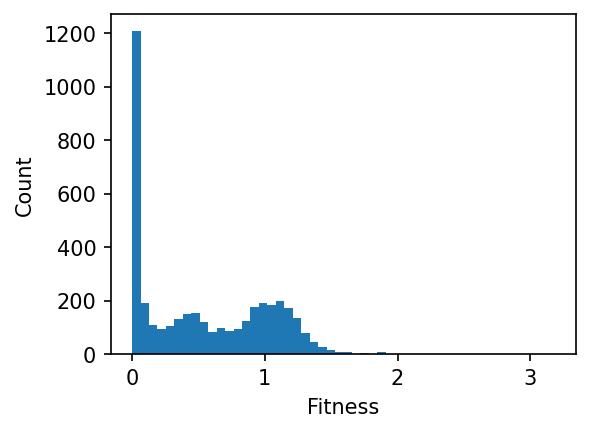

In [31]:
# plot DMS data
xsize = 4
ysize = 3
fig = plt.figure(figsize = (xsize, ysize), dpi = 150)
plt.hist(dms.flatten(), bins = 50)
plt.xlabel("Fitness")
plt.ylabel("Count")
;

As you can see there are some mutations that are neutral (fitness ~ 1) or slightly beneficial, but most mutations are completely deleterious (fitness ~ 0). 

We can now look at our predictions. One way so test the performance of mutational effect prediction is by computing the Spearman correlation between the real and the *in-silico* DMS.

In [32]:
# define range with no gaps in the protein sequence
range_no_g = [i for i, amino in enumerate(TEM1) if amino != 20]

# flatten data
dms_flat = dms[range_no_g,:].flatten()
dms_pred_flat = silico_dms_TEM[range_no_g,:].flatten()

# compute Spearman correlation
sc.spearmanr(dms_flat, dms_pred_flat)

SpearmanrResult(correlation=-0.6941990325972163, pvalue=0.0)

## Plot prediction vs experiment

To understand better let's plot the data.

In [33]:
def scatter_dms(seq, exp, h, J, index_highlight = [], lab = 'add label',):
  # size of the plot
  xsize = 3
  ysize = 3

  # data
  silico = get_silico_dms_non_sym(h,J,seq,L)
  range_no_g = [i for i, amino in enumerate(seq[:200]) if amino != 20]
  vx = silico[range_no_g,:].flatten()
  vy = exp[range_no_g,:].flatten()

  multip = 3

  # spearman correlation
  sp_val = sc.spearmanr(vx, vy)[0]

  fig = plt.figure(figsize = (xsize, ysize), dpi = 200)

  # scatter of all data
  pl1 = plt.scatter(vx, vy,s = multip*xsize, alpha = 0.4, linewidth = 0.6, 
      edgecolor = "black", color = "dodgerblue")

  # scatter of highlighted data
  if index_highlight == []:
    pass
  else:
    pl2 = plt.scatter(vx[index_highlight], vy[index_highlight],s = multip*xsize, alpha = 0.4, linewidth = 0.6, 
    edgecolor = "black", color = "red", label = lab)
    plt.legend(fontsize = 7, loc = 'lower left')


  plt.tick_params(labelsize = multip*xsize)
  plt.yscale("log")
  plt.xlim((-6, 8))
  plt.ylim((0.0005, 5))
  plt.title("Prediction of mutational effects", fontsize = 1.2*multip*xsize)
  plt.xlabel("ΔE", fontsize = multip*xsize)
  plt.ylabel("Fitness", fontsize = multip*xsize)
  plt.text(1.5, 3, f"spearman = {round(sp_val, 2)}", fontsize = 0.8*multip*xsize)
  return None

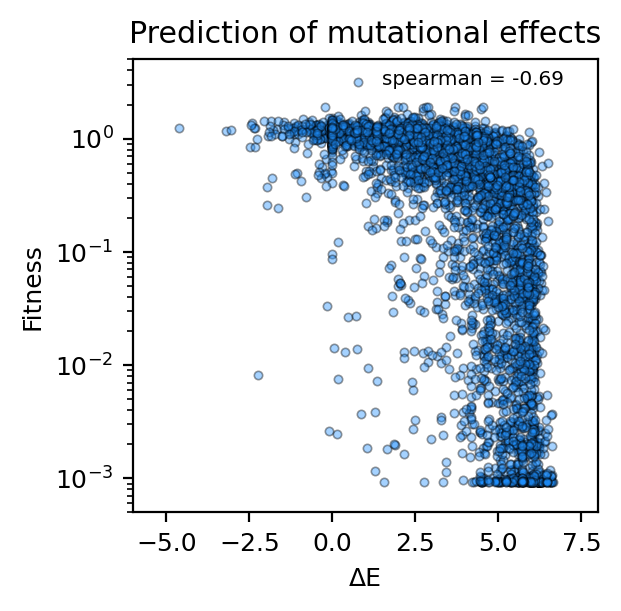

In [34]:
# scatterplot of DMS and predictions
scatter_dms(TEM1, dms, h, J)

We can highlight just some datapoint, like those with low energy, or low fitness..

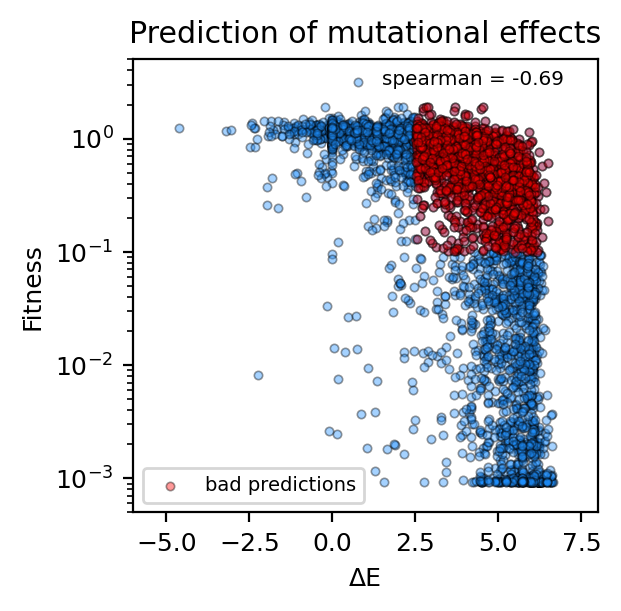

In [35]:
# to highlight data
lab = "bad predictions"
index_highlight = [index for index, ΔE in enumerate(dms_pred_flat) if ((ΔE > 2.5) and (dms_flat[index] > 0.1))]

# plot scatter
scatter_dms(TEM1, dms, h, J, index_highlight, lab)

Note that:

- The red points indicate a region of low prediction quality, mutants there are generally slightly deleterious, but deemed deleterious by the model.


- The model understands well what mutations are neutral 

- It is expecially good at understanding wich ones are deleteroious. This information is usually encoded in the fields $h_i$, but the coulings $J_{ij}$ help to refine the information and to contextualize it. 

- A prediction from a profile model, where 

  $P(s_1, s_2,...,s_L) = \prod_i^L f_i(s_i)$
  \- with $f_i$ being the frequency of the amino acid $s_i$ in the MSA \- is **context independend**, that is all proteins from the same family would yield the same prediction.

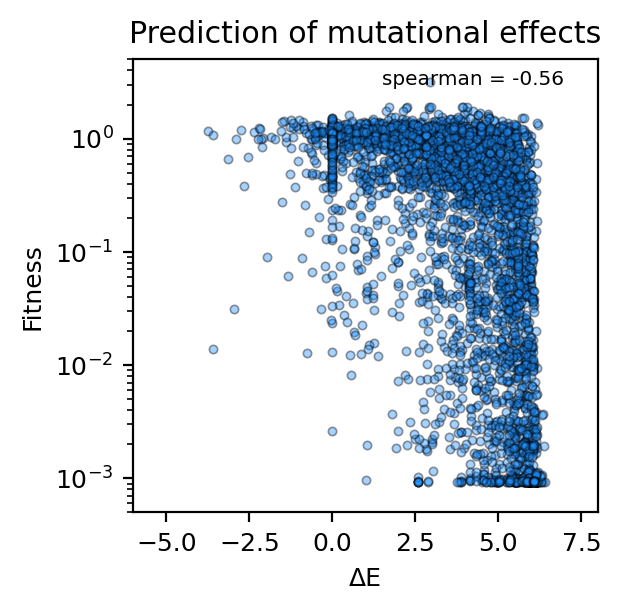

In [36]:
# scatterplot in-silico and real DMS for new sequence

# define new sequence target
seq = align[100]

# plot scatter
scatter_dms(seq, dms, h, J)

# 4) Simulate experimental evolution 

We will now use the model we have learned to simulate experimental protein evolution. Evolutionary experiments we will simulate start from a single sequence and generate many variants with multiple rounds of *mutations* and *selection* in vivo (E.Coli). The end point of such experiments is a library of variants collected in a MSA.

We will replace this complex process by MCMC sampling from the model starting grom the same wildtype (initial) sequence by making moves directly on the DNA sequence. Two papers were recently published with the some of the most extensive and advanced experiments performed so far [Fantini et al.](https://doi.org/10.1093/molbev/msz256), [Stiffler et al.](https://doi.org/10.1016/j.cels.2019.11.008). **Purely by chance** such experiments used two Betalactamase protein sequences as starting points! 


In [37]:
def cod2amino(a): 
    #to convert the codon 3 letter strings into amino acids (in number format)
    switcher = { 
        "ATA" :  7, "ATC" : 7, "ATT" : 7,  
        "ATG" : 10, 
        "ACA" : 16, "ACC" : 16, "ACG" : 16, "ACT" : 16, 
        "AAC" : 11, "AAT" : 11, 
        "AAA" : 8, "AAG" : 8, 
        "AGC" : 15, "AGT" : 15, "TCA" : 15, "TCC" : 15, "TCG" : 15, "TCT" : 15,
        "AGA" : 14, "AGG" : 14, "CGA" : 14, "CGC" : 14, "CGG" : 14, "CGT" : 14,              
        "CTA" : 9, "CTC" : 9, "CTG" : 9, "CTT" : 9, "TTA" : 9, "TTG" : 9,
        "CCA" : 12, "CCC" : 12, "CCG" : 12, "CCT" : 12, 
        "CAC" : 6, "CAT" : 6, 
        "CAA" : 13, "CAG" : 13, 
        "GTA" : 17, "GTC" : 17, "GTG" : 17, "GTT" : 17, 
        "GCA" : 0, "GCC" : 0, "GCG" : 0, "GCT" : 0, 
        "GAC" : 2, "GAT" : 2, 
        "GAA" : 3, "GAG" : 3, 
        "GGA" : 5, "GGC" : 5, "GGG" : 5, "GGT" : 5, 
        "TTC" : 4, "TTT" : 4,  
        "TAC" : 19, "TAT" : 19, 
        "TAA" : 20, "TAG" :  20, "TGA" :  20, "---"  : 20,
        "TGC" :  1, "TGT" : 1, 
        "TGG" : 18
        }
    return switcher.get(a, None)


def dH(seq1, seq2):
    #hamming distance (number of mutations) between two sequences
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

## Wildtype

We will simulate an experiment similar to the one reported by Stiffler. They used as wildtype a sequence called PSE-1. 

In [38]:
# import data from GitHub
%%bash
wget -qnc https://raw.githubusercontent.com/matteobisardi/ALGOSB_2021_tutorial/main/data/PSE-1_DNA.fasta

In [39]:
# read the DNA sequence of PSE-1
data_wt_DNA = open('PSE-1_DNA.fasta', 'r')
PSE1_DNA_string = data_wt_DNA.readlines()[1][:-1]

# split the DNA sequence in codons
PSE1_codon = [PSE1_DNA_string[ (i*3) : ((i+1)*3) ] for i in range(L)]
data_wt_DNA.close()

Here is how it looks like.

In [40]:
PSE1_codon[:10]

['---', '---', 'AAT', 'GGA', 'GAA', 'TAT', 'TGG', 'GAT', 'TAC', 'AAT']

Let's translate it into amino acids.. or numbers in our case.

In [42]:
PSE1_amino = [cod2amino(PSE1_codon[i]) for i in range(L)]
PSE1_amino[:10]

[20, 20, 11, 5, 3, 19, 18, 2, 19, 11]

<div class="alert alert-block alert-info">
<b>Note : </b>the genetic code is redundant! </div>

```python 
PSE1_codon[6] = 'TAT'
PSE1_codon[9] = 'TAC'
``` 

but 

```python 
PSE1_amino[6] = 19 aka 'Y'
PSE1_amino[9] = 19 aka 'Y'
``` 
this plays a non trivial role in evolution!

Let's now embed the data in the class `Sequence` for easier management.


In [ ]:
class Sequence(object):
    #class containing amino acid and DNA sequence
    def __init__(self, amino, codon):
        self.Amino = amino
        self.Codon = codon
        
def mutate_codon(self, new_codon, pos):
    self.Codon[pos] = new_codon

def mutate_amino(self, new_amino, pos):
    self.Amino[pos] = new_amino


PSE1 = Sequence(PSE1_amino, PSE1_codon)


The functions `mutate_codon(Sequence, new_codon, pos)` and `mutate_amino(Sequence, new_amino, pos)` allow to easely change codons and amino acids in one sequence.

Given a sequence the model allows us to compute a *score* or *energy* (for those more keen to the physics jargon). <br>The lower the score, the better the sequence. 

In [ ]:
E_PSE1 = energy(h, J, PSE1.Amino)
print(E_PSE1)

-287.12688366158216


Let's compute the energy of all natural sequences - according to the model we learned:      
<font size="3">$E(s_1, s_2,...,s_L) = - \sum_i h_i(s_i) -\sum_{i,j} J_{ij}(s_i,s_j)$</font>

In [46]:
def energy(h, J, seq):
    #energy of a sequence with symmetrized couplings
    en = 0
    L = len(seq)
    for i in range(L):
        en -= h[i*q+seq[i]]
        for j in range(i):
            en -= 0.5*(J[j*q+seq[j],i*q+seq[i]] + J[i*q+seq[i],j*q+seq[j]])
    return en

In [47]:
# compute energy of natural sequences
E_nat = [energy(h, J, align[i, :]) for i in range(M)]

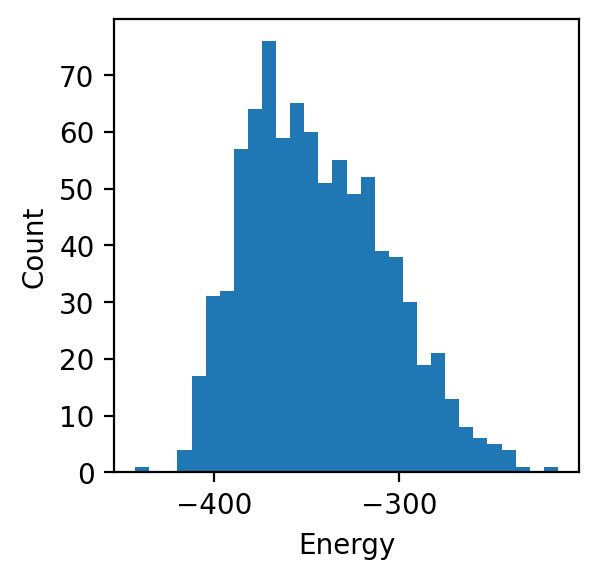

''

In [49]:
# plot distribution of energies
xsize = 3
ysize = 3
fig = plt.figure(figsize = (xsize, ysize), dpi = 200)
plt.hist(E_nat, bins = 30)
plt.xlabel("Energy")
plt.ylabel("Count")
plt.show()
;

## Evolution

Looking at the data that comes from this [Stiffler et al.](https://www.sciencedirect.com/science/article/pii/S2405471219304284") paper

In [ ]:
# import data from GitHub
%%bash
wget -qnc https://raw.githubusercontent.com/matteobisardi/ALGOSB_2021_tutorial/main/data/PSE-1_Round20_Stiffler_10000.fasta


In [ ]:
MSA_exp = fasta2matrix("PSE-1_Round20_Stiffler_10000.fasta")

M = 10000, L = 202 



Energy and Hamming distance of Stiffler's data.

In [ ]:
Mm = 100
rr = choice(range(10000), Mm)
H_exp = [dH(MSA_exp[i, :], PSE1.Amino) for i in rr]
energy_exp = [energy(h, J, MSA_exp[i, :]) for i in rr]
print(np.mean(energy_exp)  - E_PSE1)
np.mean(H_exp)

6.585304911217349


27.14

Generating an in silico alignment..

In [ ]:
M_silico = 1000
N = 202
MSA_silico = np.zeros((M_silico, N), dtype = int)
start_t = time.time()
for i in range(M_silico):
    MSA_silico[i, :] = evol_seq(PSE1, 75, h, J, N, T = 1.2).Amino
    if (i > 0) & (i%100 == 0):
        print(f"Sampled {i} sequences (out of {M_silico})")
final_t = time.time()
print("\nDone! Enjoy your results.")
print(f"The sampling has taken {round(final_t - start_t)} seconds in total (~ {round((final_t - start_t)/60)} minutes).")

Sampled 100 sequences (out of 1000)
Sampled 200 sequences (out of 1000)
Sampled 300 sequences (out of 1000)
Sampled 400 sequences (out of 1000)
Sampled 500 sequences (out of 1000)
Sampled 600 sequences (out of 1000)
Sampled 700 sequences (out of 1000)
Sampled 800 sequences (out of 1000)
Sampled 900 sequences (out of 1000)

Done! Enjoy your results.
The sampling has taken 150 seconds in total (~ 3 minutes).


Let's compute the correlation with the data.

In [ ]:
def mut_profile(ali):
    M, L = np.shape(ali)
    ali_1hot = onehot(ali)
    freq = np.sum(ali_1hot,0)/M
    return np.reshape(freq, (L, 21))

In [ ]:
print(M_silico)
ran = choice(range(10000), M_silico)
pi_prof = mut_profile(MSA_silico)
pi_exp = mut_profile(MSA_exp[ran, :])
sc.spearmanr(pi_prof.flatten(),pi_exp.flatten())

1000


SpearmanrResult(correlation=0.7489484058834027, pvalue=0.0)

In [ ]:
print(M_silico)
ran1 = choice(range(10000), 1000)
pi_1 = mut_profile(MSA_exp[ran1, :])
ran2 = choice(range(10000), 1000)
pi_2 = mut_profile(MSA_exp[ran2, :])
sc.spearmanr(pi_1.flatten(),pi_2.flatten())

1000


SpearmanrResult(correlation=0.872386160427419, pvalue=0.0)

Let's see them in a nice plot.

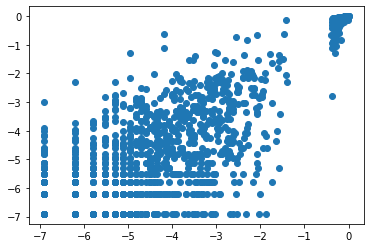

In [ ]:
plt.scatter(np.log(mut_profile(MSA_silico[1:1000]).flatten()),
            np.log(mut_profile(MSA_exp[1:1000]).flatten()))

In [ ]:

def normalize(vec):
    return vec/np.sum(vec)


def cond_prob(position, amino_list, seq, h, J, N, T = 1):
    #conditional probability of amino acid a_i in site i given the rest of the sequence
    proba_vec = np.zeros(len(amino_list))  
    for k, amino in enumerate(amino_list):
        log_proba = h[position*q + amino]
        for i in range(N):
            log_proba += J[i*q + seq[i], position*q + amino]
        proba_vec[k] = np.exp(log_proba/T)
    return normalize(proba_vec)

def cond_prob_sym(position, amino_list, seq, h, J, N, T = 1):
    #conditional probability of amino acid a_i in site i given the rest of the sequence with symmetrized couplings
    proba_vec = np.zeros(len(amino_list))  
    for k, amino in enumerate(amino_list):
        log_proba = h[position*q + amino]
        for i in range(N):
            log_proba += 0.5*(J[i*q + seq[i], position*q + amino] + J[position*q + amino, i*q + seq[i]])
        proba_vec[k] = np.exp(log_proba/T)
    return normalize(proba_vec)

def accessible_states(old_codon):
    #given a codon returns the list of amino acids reachable from that codon with one DNA mutation
    old_codon = np.array([lettr for lettr in old_codon])
    codon_list = []
    for i in range(3):
        mutated_cod = np.copy(old_codon)
        for lettr in "ACGT":
            mutated_cod[i] = lettr
            if cod2amino("".join(mutated_cod)) != 20 :
                codon_list.append("".join(mutated_cod) )
    amino_list = list(set(map(cod2amino, codon_list)))
    return codon_list, amino_list
        
def evol_seq(seq, MC_steps, h, J, N, T = 1):
    #given a sequence returns an "evolved" sequence, that is a sequence with mutations introduced with Gibbs sampling
    mutated_seq = deepcopy(seq)
    non_gapped_pos = np.array([pos for pos, amino in enumerate(seq.Amino) if amino != 20])
    for steps in range(MC_steps):
        pos_mut = choice(non_gapped_pos)
        old_codon = mutated_seq.Codon[pos_mut]
        codon_list, amino_list = accessible_states(old_codon)
        cond_proba = cond_prob(pos_mut, amino_list, mutated_seq.Amino, h, J, N, T)
        new_amino = choice(amino_list, 1, p = cond_proba)[0]
        new_codon = choice([codon for codon in codon_list if cod2amino(codon) == new_amino])
        mutate_codon(mutated_seq, new_codon, pos_mut)
        mutate_amino(mutated_seq, new_amino, pos_mut)
    return mutated_seq

def evol_seq_sym(seq, MC_steps, h, J, N, T = 1):
    #symmetrized couplings version
    mutated_seq = deepcopy(seq)
    non_gapped_pos = np.array([pos for pos, amino in enumerate(seq.Amino) if amino != 20])
    for steps in range(MC_steps):
        pos_mut = choice(non_gapped_pos)
        old_codon = mutated_seq.Codon[pos_mut]
        codon_list, amino_list = accessible_states(old_codon)
        cond_proba = cond_prob_sym(pos_mut, amino_list, mutated_seq.Amino, h, J, N, T)
        new_amino = choice(amino_list, 1, p = cond_proba)[0]
        new_codon = choice([codon for codon in codon_list if cod2amino(codon) == new_amino])
        mutate_codon(mutated_seq, new_codon, pos_mut)
        mutate_amino(mutated_seq, new_amino, pos_mut)
    return mutated_seq

def evol_seq_profile(seq, MC_steps, p_prof, N, T = 1):
    #profile model version
    mutated_seq = deepcopy(seq)
    non_gapped_pos = np.array([pos for pos, amino in enumerate(seq.Amino) if amino != 20])
    for steps in range(MC_steps):
        pos_mut = choice(non_gapped_pos)
        old_codon = mutated_seq.Codon[pos_mut]
        codon_list, amino_list = accessible_states(old_codon)
        prob = p_prof[pos_mut*21 : pos_mut*21 + 21 ][amino_list]
        prob /= sum(prob)
        new_amino = choice(amino_list, 1, p = prob)[0]
        new_codon = choice([codon for codon in codon_list if cod2amino(codon) == new_amino])
        mutate_codon(mutated_seq, new_codon, pos_mut)
        mutate_amino(mutated_seq, new_amino, pos_mut)
    return mutated_seq
  
 